# Environment setup

## Download code and data


In [ ]:
!pip install imagecodecs tifffile

     |████████████████████████████████| 17.9MB 203kB/s 


In [ ]:
# Clone the GitHub repository and cd into it
!git clone 'https://github.com/CRefice/ml-segmentation-project.git'
%cd ml-segmentation-project/

Cloning into 'ml-segmentation-project'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 213 (delta 114), reused 83 (delta 35), pack-reused 0
Receiving objects: 100% (213/213), 7.82 MiB | 9.41 MiB/s, done.
Resolving deltas: 100% (114/114), done.
/content/ml-segmentation-project


In [ ]:
# Download the data using the fetch script
!./fetch-data.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72.8M  100 72.8M    0     0  5973k      0  0:00:12  0:00:12 --:--:-- 10.8M


## Useful imports and settings

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pathlib import Path
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms, datasets, models
import copy
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage.segmentation import watershed, find_boundaries
from skimage.feature import peak_local_max
import os,sys
import pandas as pd
import time
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as data

import unet
from dataset import CellSegmentationDataset, PadToSize
from early_stop import EarlyStopping


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data importing and massaging

Now we import the dataset and create train/test splitters.

In [ ]:
BATCH_SIZE = 2
TRAIN_PERCENT = 0.8
CLASS_NUMBER = 3
IMG_SIZE = 1024

def create_classes(label):
    return torch.clamp(label.clamp(max = 1) + 2 * find_boundaries(label), max = 2)

img_transform = transforms.Compose([
    # Convert to 0-1 float
    transforms.Lambda(lambda img: (img.astype(np.float32) - np.min(img)) / (np.max(img) - np.min(img))),  
    transforms.ToTensor(),
    PadToSize(IMG_SIZE),
])

target_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.astype(np.float32)),
    transforms.ToTensor(),
    PadToSize(IMG_SIZE),
])

target_binary_transform = transforms.Compose([
    target_transform,
    # Limit to 0-1 for foreground-background segmentation
    transforms.Lambda(lambda img: img.clamp(max=1.0)),
])

target_boundary_transform = transforms.Compose([
    target_transform,
    transforms.Lambda(lambda img: img.long()),
    transforms.Lambda(create_classes),
])

target_transform = target_boundary_transform if CLASS_NUMBER > 2 else target_binary_transform

def create_dataset(img_transform, target_transform):
    return CellSegmentationDataset(raw_img_dir=Path("dataset/rawimages"),
                                  ground_truth_dir=Path("dataset/groundtruth"),
                                  transform=img_transform,
                                  target_transform=target_transform
                                )


We now augment the dataset with flipped/rotated copies of the image.

In [ ]:
def augment(augm):
    return create_dataset(
        transforms.Compose([
            img_transform,
            transforms.Lambda(augm),
        ]), 
        transforms.Compose([
            target_transform,
            transforms.Lambda(augm),
            transforms.Lambda(lambda img: img.squeeze())
        ])
    )

def rotation(degrees):
    return lambda img: TF.rotate(img, degrees)

basic_dataset = augment(lambda x: x)
augmented_copies = [
    basic_dataset,
    augment(TF.hflip),
    augment(TF.vflip),
    augment(lambda img: TF.hflip(TF.vflip(img))),
    augment(rotation(90)),
    augment(rotation(180)),
    augment(rotation(270)),
]

augmented_dataset = data.ConcatDataset(augmented_copies)

In [ ]:
train_size = int(len(augmented_dataset) * TRAIN_PERCENT)
test_size = len(augmented_dataset) - train_size

train_dataset, val_dataset = data.random_split(augmented_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Training

In [ ]:
model = unet.UNet(num_classes=CLASS_NUMBER).to(device)
summary(model, input_size=(1, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 64, 1024, 1024]             640
              ReLU-2       [-1, 64, 1024, 1024]               0
            Conv2d-3       [-1, 64, 1024, 1024]          36,928
              ReLU-4       [-1, 64, 1024, 1024]               0
         MaxPool2d-5         [-1, 64, 512, 512]               0
            Conv2d-6        [-1, 128, 512, 512]          73,856
              ReLU-7        [-1, 128, 512, 512]               0
            Conv2d-8        [-1, 128, 512, 512]         147,584
              ReLU-9        [-1, 128, 512, 512]               0
        MaxPool2d-10        [-1, 128, 256, 256]               0
           Conv2d-11        [-1, 256, 256, 256]         295,168
             ReLU-12        [-1, 256, 256, 256]               0
           Conv2d-13        [-1, 256, 256, 256]         590,080
             ReLU-14        [-1, 256, 2

We first define the evaluation functions we'll be using during training.

In [ ]:
def batch_dot(a, b):
    batch_size = a.size()[0]
    a = a.view(batch_size, 1, -1).float()
    b = b.view(batch_size, -1, 1).float()
    return a.bmm(b).squeeze()

def batch_sum(a):
    batch_size = a.size()[0]
    return a.view(batch_size, -1).sum(dim = 1)

def dice_loss(input, target):
    target = F.one_hot(target).permute(0, 3, 1, 2).contiguous()
    eps = 0.0001
    inter = batch_dot(input, target)
    union = batch_sum(input ** 2) + batch_sum(target ** 2) + eps
    t = (2 * inter.float() + eps) / union.float()
    return 1 - t.mean()

In [ ]:
def evaluate(model, loader, criterion):
    n_val = len(loader)
    tot = 0
    with torch.no_grad():
        for image, labels in loader:
            pred = model(image.to(device))
            tot += criterion(pred, labels.to(device))
    return tot / n_val

In [ ]:
def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    es = EarlyStopping(patience=5)

    for epoch in range(num_epochs):
        since = time.time()

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Training phase
        model.train()

        epoch_loss = 0
        epoch_samples = len(train_loader)
            
        torch.cuda.empty_cache()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()   
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()    
            epoch_loss += loss.item()

        #scheduler.step()
        
        print("Epoch train loss: {}".format(epoch_loss / epoch_samples))
        # print("Epoch dice loss: {}".format(epoch_dice_loss / epoch_samples))

        # Evaluation phase
        model.eval()
        val_loss = evaluate(model, val_loader, criterion)
        if es.step(val_loss):
          break  # early stop criterion is met, we can stop now

        if val_loss < best_loss:
            best_model_wts = copy.deepcopy(model.state_dict())
            best_loss = val_loss

        print("Epoch validation loss: {}".format(val_loss))

        time_elapsed = time.time() - since
        print('Took {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    model.load_state_dict(best_model_wts)
    return model, best_loss

In [ ]:
def combined_loss(criterion1, criterion2, mix=.5):
    def loss(output, labels):
        return mix * criterion1(output, labels) + (1 - mix) * criterion2(output, labels)
    
    return loss

In [ ]:
def find_occupancy(labels):
    occupancies = torch.empty(CLASS_NUMBER)
    num_samples = 0
    for label in labels:
        for clas in range(CLASS_NUMBER):
            occupancies[clas] += torch.count_nonzero(label == clas)
        num_samples += torch.numel(label)
    return occupancies / num_samples

def find_class_weights(dataset):
    occ = find_occupancy((label for (image, label) in dataset))
    occ = 1 / occ.sqrt()
    return occ / sum(occ)

weights = find_class_weights(basic_dataset).to(device)

In [ ]:
TRN_EPOCHS = 20
WEIGHT_DECAY = 0
LEARNING_RATE = 0.001
MOMENTUM = 0.99

torch.cuda.empty_cache()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
if CLASS_NUMBER > 2:
    criterion = combined_loss(
        nn.CrossEntropyLoss(weights),
        dice_loss
    )
else:
    criterion = nn.BCEWithLogitsLoss()

# Maybe interesting to use later
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
model, best_loss = train_model(model, optimizer, criterion, exp_lr_scheduler, num_epochs=TRN_EPOCHS)

Epoch 1/20
----------
Epoch train loss: 0.36547462830985833
Epoch validation loss: 0.2926895320415497
Took 8m 25s

Epoch 2/20
----------
Epoch train loss: 0.3023754850501928
Epoch validation loss: 0.2889572083950043
Took 8m 20s

Epoch 3/20
----------
Epoch train loss: 2.1105062348001145
Epoch validation loss: 0.30326515436172485
Took 8m 17s

Epoch 4/20
----------
Epoch train loss: 0.3082491798638219
Epoch validation loss: 0.2936631441116333
Took 8m 7s

Epoch 5/20
----------
Epoch train loss: 0.30297085433793824
Epoch validation loss: 0.29056066274642944
Took 8m 8s

Epoch 6/20
----------
Epoch train loss: 0.29912308310221764
Epoch validation loss: 0.2879532277584076
Took 8m 6s

Epoch 7/20
----------
Epoch train loss: 0.28907392399882836
Epoch validation loss: 0.27861806750297546
Took 8m 4s

Epoch 8/20
----------
Epoch train loss: 0.28558354329199814
Epoch validation loss: 0.27923575043678284
Took 8m 4s

Epoch 9/20
----------
Epoch train loss: 0.284663345546744
Epoch validation loss: 0.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the model
torch.save(model.state_dict(), "/content/drive/MyDrive/trained-unet.model")

### Grid search

In [ ]:
hyper_params = {'learning_rate' : [0.002, 0.0002],
                'depth' : [3,4],
                'optimizer' : [torch.optim.Adam, torch.optim.Adagrad, torch.optim.SGD]
                }

In [ ]:
def grid_search(params_dict, CLASS_NUMBER, WEIGHT_DECAY):

  best_loss = float("inf")
  best_params = {}

  if CLASS_NUMBER > 2:
    criterion = combined_loss(
        nn.CrossEntropyLoss(weights),
        dice_loss
      )
  else:
    criterion = nn.BCEWithLogitsLoss() 
 
  keys, values = zip(*params_dict.items())

  for v in itertools.product(*values):
    hp_dict = dict(zip(keys, v))
    print(hp_dict)

    model = unet.UNet(num_classes=CLASS_NUMBER, depth=hp_dict['depth']).to(device)
    optimizer = hp_dict['optimizer'](model.parameters(), lr=hp_dict['learning_rate'], weight_decay=WEIGHT_DECAY)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

    model, loss = train_model(model, optimizer, criterion, exp_lr_scheduler, num_epochs=2)

    if loss < best_loss:
      ref_loss = best_loss
      best_params = hp_dict

In [ ]:
TRN_EPOCHS = 20
WEIGHT_DECAY = 0
MOMENTUM = 0.99

grid_search(hyper_params, CLASS_NUMBER, WEIGHT_DECAY)

{'learning_rate': 0.002, 'depth': 3, 'optimizer': <class 'torch.optim.adam.Adam'>}
Epoch 1/2
----------
Epoch train loss: 0.3253149733419332
Epoch validation loss: 0.3034786581993103
Took 5m 28s

Epoch 2/2
----------
Epoch train loss: 0.2937904284820298
Epoch validation loss: 0.2967245280742645
Took 5m 27s

{'learning_rate': 0.002, 'depth': 3, 'optimizer': <class 'torch.optim.sgd.SGD'>}
Epoch 1/2
----------
Epoch train loss: 0.862574518536011
Epoch validation loss: 0.7123562097549438
Took 5m 39s

Epoch 2/2
----------


KeyboardInterrupt: ignored

# Generating predictions

We now generate predictions for one batch of data and compare it to the ground truth.

In [ ]:
def show_results(inputs, labels, outputs):
    plt.gray()
    count = len(inputs)
    fig = plt.figure(figsize=(6 * 3, 6 * count))
    axs = fig.subplots(count, 3)
    
    for ax in axs.flat:
        ax.axis("off")
    
    column_labels = ["Input image", "Ground truth", "Generated prediction"]

    if count == 1:
        for ax, label in zip(axs, column_labels):
            ax.set_title(label)
        
        for i in range(count):
            axs[0].imshow(inputs[i].squeeze())
            axs[1].imshow(labels[i].squeeze())
            axs[2].imshow(outputs[i].squeeze())
    else:
        for ax, label in zip(axs[0], column_labels):
            ax.set_title(label)
        
        for i in range(count):
            axs[i, 0].imshow(inputs[i].squeeze())
            axs[i, 1].imshow(labels[i].squeeze())
            axs[i, 2].imshow(outputs[i].squeeze())
    
    fig.show()

def show_image(image):
    plt.imshow(image.squeeze())

<Figure size 432x288 with 0 Axes>

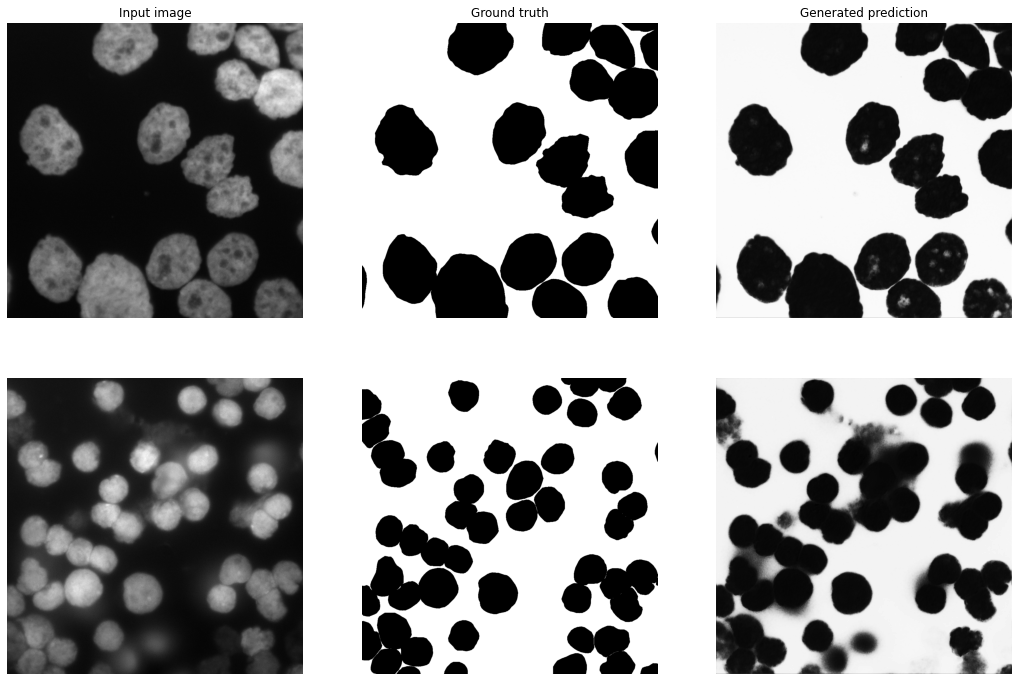

In [ ]:
inputs, labels = next(iter(val_loader))
outputs = model.predict(inputs.to(device))

class_idx = 0
show_results(inputs, labels == class_idx, outputs[:, class_idx])

In [ ]:
def label_with_watershed(image, min_distance=50):
  """
    Inputs
      image: Image to be labelled
      min_distance: Minimum distance that cell-centers should be apart of eachother in
                    pixels
    Outputs:
      Labelled image with every cell having a different value (v > 0) and a border
      between every cell (1-pixel wide)
  """
  # Euclidean distance matrix of the image
  distance = ndi.distance_transform_edt(image)
  # List of (x,y) pairs representing the coordinates of the peaks
  coords_of_peaks = peak_local_max(distance, min_distance=min_distance, footprint=np.ones((64,64)), labels=image)
  # Black image with white pixels representing the peaks (cell-centers)
  mask = np.zeros(distance.shape, dtype=bool)
  mask[tuple(coords_of_peaks.T)] = True
  # Mask transformed to having a different value per peak (cell-center)
  markers, _ = ndi.label(mask)

  # Return the watershed labels, use -distance because watershed works on minima.
  return watershed(-distance, markers, mask=image, watershed_line=True)

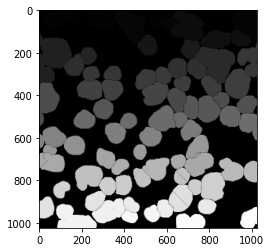

In [ ]:
# Example:
show_image(label_with_watershed(labels[0].numpy()))

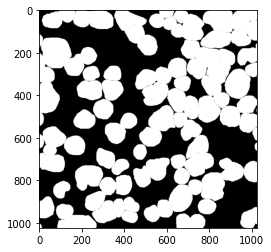

In [ ]:
show_image(labels[0].numpy())


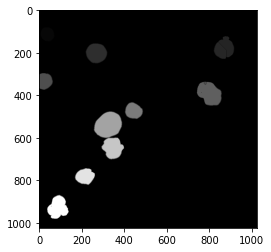

In [ ]:
show_image(label_with_watershed(labels[1].numpy()))

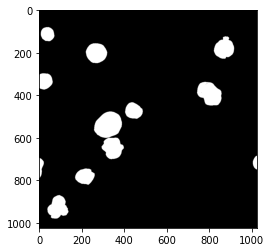

In [ ]:
show_image(labels[1].numpy())
